In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Utils.dataset import PreloadedDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import math

In [2]:
# device = torch.device('cuda') if torch.cuda.is_available() else "cpu"ArithmeticError
device = torch.device('cpu')
device

device(type='cpu')

  0%|          | 0/1000 [00:00<?, ?it/s]

Loaded MNIST with 1000 samples


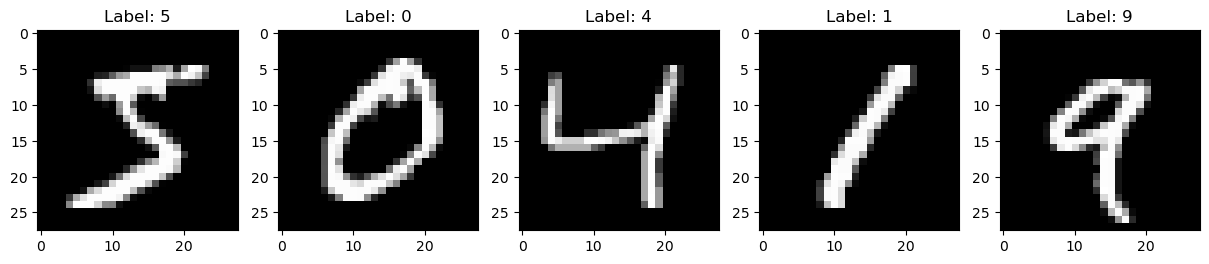

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

subset_size = 1000
raw_dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=False)
raw_dataset = torch.utils.data.Subset(raw_dataset, range(subset_size))

positive_dataset = PreloadedDataset.from_dataset(raw_dataset, transforms.ToTensor(), device)
print(f'Loaded MNIST with {len(positive_dataset)} samples')
# show first samples
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(positive_dataset[i][0].numpy()), cmap='gray')
    axs[i].set_title(f"Label: {positive_dataset[i][1]}")
plt.show()

In [4]:
def mix_images(x1, x2, steps=10):
    mask = torch.bernoulli(torch.ones((28,28))*0.5).unsqueeze(0).unsqueeze(0)
    # blur  with a filter of the form [1/4, 1/2, 1/4] in both horizontal and veritical directions
    filter_h = torch.tensor([[1/4, 1/2, 1/4]])
    filter_v = torch.tensor([[1/4], [1/2], [1/4]])
    for _ in range(5):
        mask = F.conv2d(mask, filter_h.unsqueeze(0).unsqueeze(0), padding='same')
        mask = F.conv2d(mask, filter_v.unsqueeze(0).unsqueeze(0), padding='same')

    
    # threshold at 0.5
    mask_1 = mask > 0.5
    mask_2 = mask <= 0.5

    out = x1*mask_1 + x2*mask_2
    return out.squeeze(0)

Loaded MNIST with 1000 samples


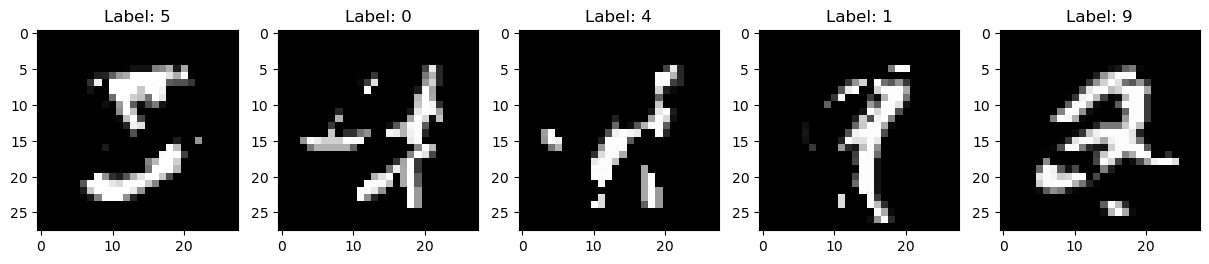

In [5]:
# Create second dataset using the mix func to build negative examples
negative_dataset = PreloadedDataset.from_dataset(raw_dataset, transforms.ToTensor(), device)
print(f'Loaded MNIST with {len(negative_dataset)} samples')

def mix_dataset(dataset):
    for i in range(len(dataset)):
        j = i + 1 if i < len(dataset) - 1 else 0
        dataset.transformed_images[i] = mix_images(dataset.images[i], dataset.images[j])
    return dataset

negative_dataset = mix_dataset(negative_dataset)

# show first samples
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(negative_dataset[i][0].numpy()), cmap='gray')
    axs[i].set_title(f"Label: {negative_dataset[i][1]}")
plt.show()


In [52]:
class Model(nn.Module):

    def __init__(self, in_features, out_features, hiddens=[], steps=5, corr_coeff=1.0):
        super(Model, self).__init__()
        self.shape = [in_features] + hiddens + [out_features]
        self.steps = steps
        self.corr_coeff = corr_coeff
        layers = []
        for h in hiddens:
            layers.append(nn.Linear(h, in_features))
            in_features = h
        layers.append(nn.Linear(out_features, in_features))
        self.layers = nn.ModuleList(layers)

    # Returns a list of [error, belief] pairs for each layer
    def init_state(self, batch_size=1, device='cpu'):
        state = [[
            torch.zeros((batch_size, self.shape[i])).to(device), 
            torch.zeros((batch_size, self.shape[i+1])).to(device)
        ] for i in range(len(self.shape)-1)]
        return state

    def step(self, x, state=None, y=None):
        if state is None:
            state = self.init_state(len(x))
        inp = x
        for i in range(len(self.layers)):
            state[i][0] = inp - self.layers[i](state[i][1]) # Error
            state[i][1] = state[i][1] + F.linear(state[i][0], self.layers[i].weight.T) # Belief
            inp = state[i][1]
        if y is not None:
            y_norm = y / torch.norm(y)
            y_scaled = y_norm * torch.norm(state[-1][1])
            state[-1][1] = (1-self.corr_coeff)*state[-1][1] + self.corr_coeff*y_scaled
        return state

    def forward(self, x, state=None, y=None, steps=None):
        if steps is None:
            steps = self.steps
        for _ in range(steps):
            state = self.step(x, state, y)
        return state

In [68]:
# Returns the average absolute error for each layer
def eval_errs(
        model,
        dataloader,
):
    E = [-1.0 for _ in range(len(model.layers))]
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.flatten(start_dim=1)
        state = model(images, steps=5)
        for i, (e,_) in enumerate(state):
            E[i] += e.abs().mean()
    for i in range(len(E)):
        E[i] /= batch_idx+1
    return E


def train(
        model,
        positive_dataset,
        negative_dataset,
        batch_size,
        lr,
        epochs,
        reg_coeff=1.0,
        measure_errs_every=1,
        step=0,
):
    # writer = SummaryWriter("Deep_Learning/Experimental/Hebbian_Learning/mnist/out/logs")
    Es = [[] for _ in range(len(model.layers))]
    positive_dataloader = torch.utils.data.DataLoader(positive_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        negative_dataset = mix_dataset(negative_dataset)
        negative_dataloader = torch.utils.data.DataLoader(negative_dataset, batch_size=batch_size, shuffle=True)
        
        loop = tqdm(enumerate(positive_dataloader), total=len(positive_dataloader), leave=False) 
        if epoch > 0:
            temp_e = torch.zeros(len(model.layers))
            for i in range(len(model.layers)):
                temp_e[i] = Es[i][-1]
            loop.set_description(f"Epoch [{epoch+1}/{epochs}] - E: {temp_e.mean().item():.6f}")
        neg_it = iter(negative_dataloader)
        for batch_idx, (images, y) in loop:
            images = images.flatten(start_dim=1).to(device)
            y = F.one_hot(y, num_classes=10).float().to(device)
            b_size = len(images)

            for phase in range(2):
                phase_coeff = 1.0
                if phase == 1: # Negative phase
                    images = next(neg_it)[0].flatten(start_dim=1)
                    phase_coeff = -0.5
                    y = None

                state = model.init_state(b_size, device)
                for step_i in range(model.steps):
                    with torch.no_grad():
                        state = model.step(images, state, y)
                    if step_i > 0:
                        model.zero_grad()
                        
                        for i in range(len(model.layers)):
                            model.layers[i].weight.grad = -(state[i][0].T @ state[i][1]) / b_size
                            if model.layers[i].bias is not None:
                                mean = images.mean(axis=0) if i == 0 else state[i-1][1].mean(axis=0)
                                model.layers[i].bias.grad = model.layers[i].bias - mean

                        reg = reg_coeff * sum(l.weight.square().mean() for l in model.layers)
                        reg.backward()

                        # Parameter Update
                        for i in range(len(model.layers)):
                            model.layers[i].weight.data -= phase_coeff*lr*model.layers[i].weight.grad
                            if model.layers[i].bias is not None:
                                model.layers[i].bias.data -= phase_coeff*lr*model.layers[i].bias.grad

            step += len(images)

        if epoch % measure_errs_every == 0:
            E = eval_errs(model, positive_dataloader)
            for i, e in enumerate(E):
                Es[i].append(e.item())

    return Es, step

In [69]:
model = Model(784, 10, [256, 64])
for layer in model.layers:
    layer.weight.data *= 0.01
step = 0

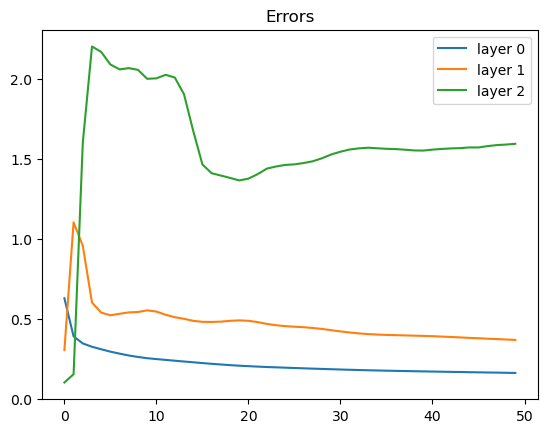

In [70]:
BATCH_SIZE = 50
LR = 0.00034
REG_COEFF = 0.2
EPOCHS=50
Es, step = train(
    model,
    positive_dataset,
    negative_dataset,
    BATCH_SIZE,
    LR,
    EPOCHS,
    reg_coeff=REG_COEFF,
    step=step,
)
# plot logarithmic
for i, e in enumerate(Es):
    plt.plot(e, label=f'layer {i}')
# plt.yscale('log')
plt.legend()
plt.title('Errors')
plt.show()

In [71]:
positive_sample = positive_dataset[0][0].flatten().unsqueeze(0)
negative_sample = negative_dataset[0][0].flatten().unsqueeze(0)
random_sample = torch.randn_like(positive_sample)

out1 = model(positive_sample, steps=1)
out2 = model(negative_sample, steps=1)
out3 = model(random_sample, steps=1)

print(out1[0][0].abs().mean())
print(out1[1][0].abs().mean())
print(out1[2][0].abs().mean())
print(out2[0][0].abs().mean())
print(out2[1][0].abs().mean())
print(out2[2][0].abs().mean())
print(out3[0][0].abs().mean())
print(out3[1][0].abs().mean())
print(out3[2][0].abs().mean())


tensor(0.5823, grad_fn=<MeanBackward0>)
tensor(0.9280, grad_fn=<MeanBackward0>)
tensor(1.6719, grad_fn=<MeanBackward0>)
tensor(0.5849, grad_fn=<MeanBackward0>)
tensor(0.8745, grad_fn=<MeanBackward0>)
tensor(1.6803, grad_fn=<MeanBackward0>)
tensor(0.8188, grad_fn=<MeanBackward0>)
tensor(0.7245, grad_fn=<MeanBackward0>)
tensor(1.6733, grad_fn=<MeanBackward0>)
